In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import desc


In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare (engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)
session

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print(f"The most recent date in the data set is {recent_date[0]}.")

The most recent date in the data set is 2017-08-23.


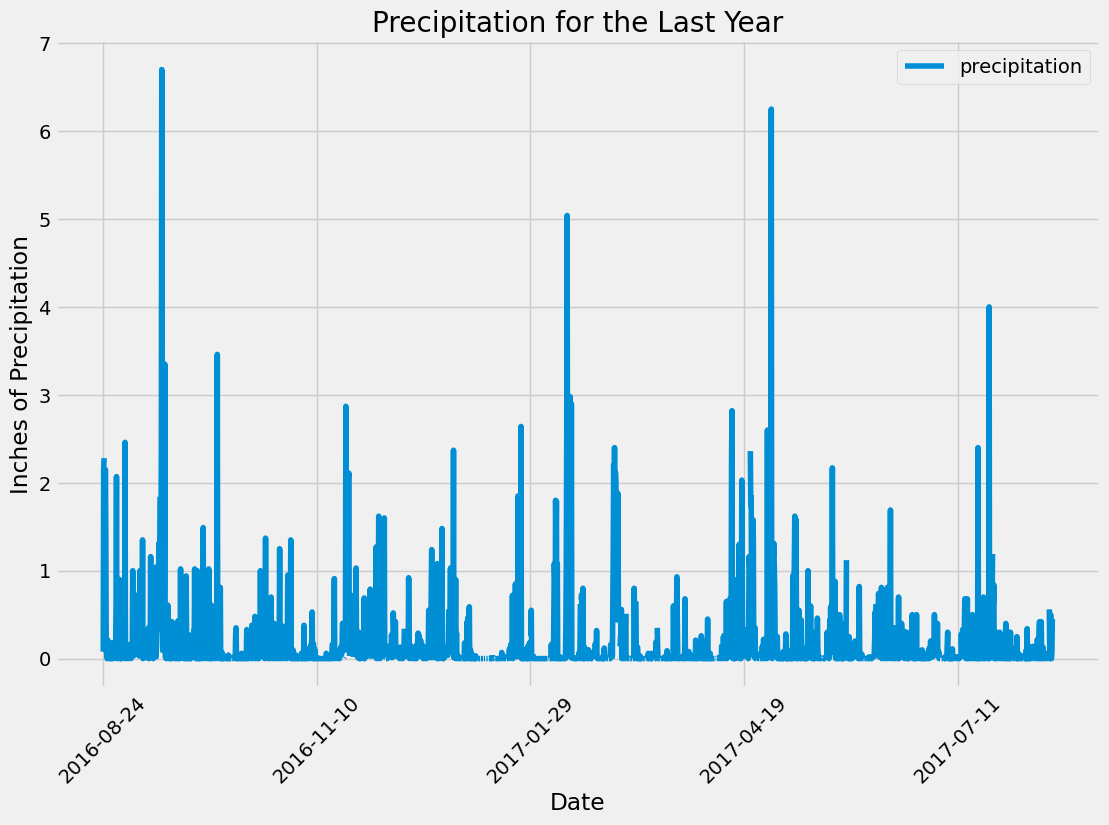

In [10]:
# Starting from the most recent data point in the database.
# Convert the query results to a Pandas DataFrame.
last_date = dt.datetime.strptime(recent_date.date, '%Y-%m-%d').date()

# Calculate the date one year from the last date in data set.
query_date = last_date - dt.timedelta(days=364)

# Perform a query to retrieve the data and precipitation scores
recent_measurement = session.query(Measurement.date, Measurement.prcp)\
                    .filter(func.strftime('%Y-%m-%d', Measurement.date) >= query_date)\
                    .order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
recent_measurement_df = pd.DataFrame(recent_measurement, columns=['date', 'precipitation'])

# Convert the 'precipitation' column to a float.
recent_measurement_df['precipitation'] = recent_measurement_df['precipitation'].astype(float)

# Set the index to the 'date' column.
recent_measurement_df.set_index('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data.
recent_measurement_df.plot(rot=45, figsize=(12,8))
plt.title("Precipitation for the Last Year")
plt.xlabel("Date")
plt.ylabel("Inches of Precipitation")
plt.show()


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
recent_measurement_df.describe()


,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(Station.station)).all()


[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(desc(func.count(Measurement.station)))\
    .all()

for station in active_stations:
    print(station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [14]:
# Get the station ID with the highest number of observations
most_active_station = session.query(Measurement.station)\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .first()[0]

# Query the tobs column for the most active station
temp_data = session.query(Measurement.tobs)\
    .filter(Measurement.station == most_active_station)\
    .all()

# Calculate the lowest, highest, and average temperature for the most active station
lowest_temp = session.query(func.min(Measurement.tobs))\
    .filter(Measurement.station == most_active_station)\
    .scalar()

highest_temp = session.query(func.max(Measurement.tobs))\
    .filter(Measurement.station == most_active_station)\
    .scalar()

avg_temp = session.query(func.avg(Measurement.tobs))\
    .filter(Measurement.station == most_active_station)\
    .scalar()

print(f"The most active station id is {most_active_station}.")
print(f"The lowest temperature is {lowest_temp}.")
print(f"The highest temperature is {highest_temp}.")
print(f"The average temperature is {avg_temp}.")

The most active station id is USC00519281.
The lowest temperature is 54.0.
The highest temperature is 85.0.
The average temperature is 71.66378066378067.


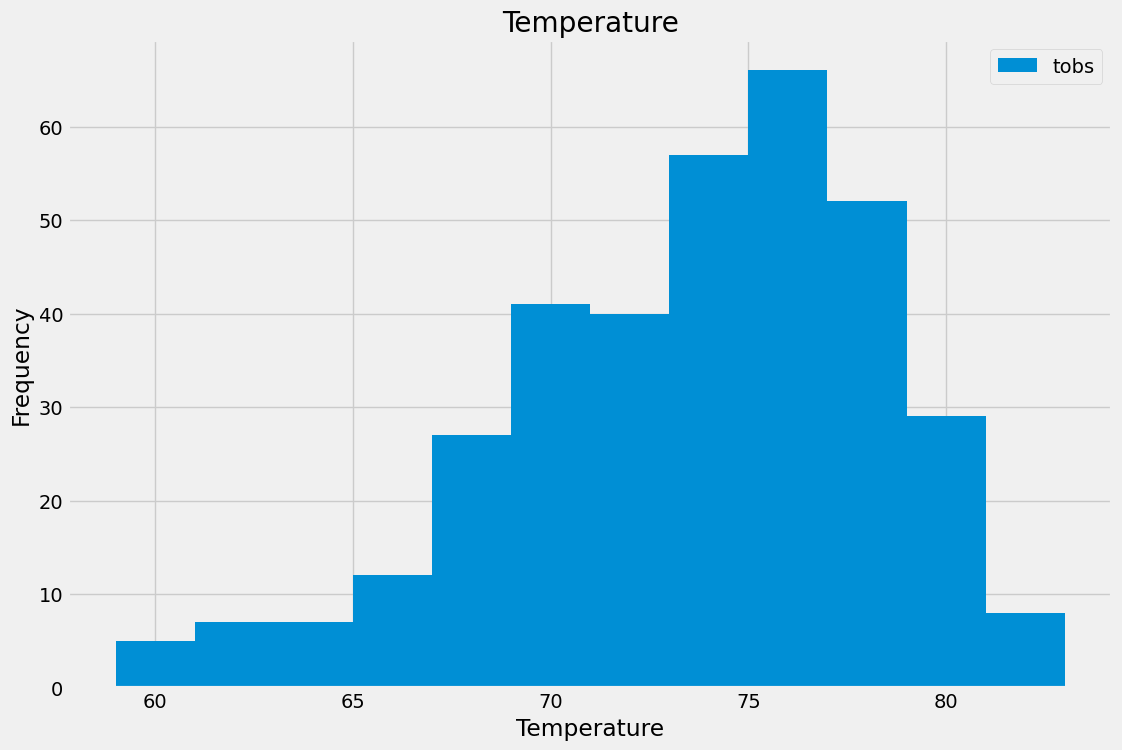

In [42]:
# Query the most active station
most_active_station = session.query(Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()[0]

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
year_ago = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Query the last 12 months of temperature observation data for the most active station
last_year_temps = session.query(Measurement.tobs)\
                          .filter(Measurement.station == most_active_station)\
                          .filter(Measurement.date >= year_ago)\
                          .all()

# Calculate the date 1 year ago from today
#year_ago = current_date - timedelta(days=365)
current_date = dt.date.today()

# Create a pandas dataframe and plot a histogram
last_year_temps_df = pd.DataFrame(last_year_temps, columns=['Temperature'])
last_year_temps_df.hist(bins=12, figsize=(12,8))
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['tobs'])
plt.show()

# Close session

In [ ]:
# Close Session
session.close()